In [1]:
%load_ext autoreload
%autoreload 2

In [330]:
import numpy as np
import networkx as nx
from scipy.sparse import lil_matrix, csr_matrix, vstack
import copy
import os
import helper
from wl import *
from joblib import Parallel, delayed
from time import time
import matplotlib.pyplot as plt
from glob import glob
import math
import pandas as pd
import collections
import sklearn
import psutil
import pickle
from matplotlib import cm
from IPython.display import display

In [200]:
GRAPH_DIR = 'data/ng-20-single-document'
ORIGINAL_DOCUMENTS_DIR = 'extract-concept-graphs/code/data/ng20__single/train'

In [263]:
def flatten(l, as_set = False):
    return functools.reduce(lambda acc, x: acc | set(x) if as_set else acc + list(x), l, set() if as_set else list())

## Retrieve graphs from Tobias' concept-graph extraction library

In [242]:
def get_graphs(directory, ext = 'gml', undirected = False, verbose = False):
    graphs = {}
    empty_graphs = []
    files = sorted(glob(directory + '/*' + ext))
    graph_ids = []
    for idx, graph_file in helper.log_progress(list(enumerate(files)), every = 100):
        topic_and_id = graph_file.split('/')[-1].replace('.gml', '')
        
        topic = topic_and_id.split('_')[0]
        if topic not in graphs:
            graphs[topic] = []
        with open(graph_file) as f:
            graph = f.read().split('\n')
        for idx, line in enumerate(graph):
            if line.startswith('label'):
                next_line = graph[idx + 1]
                label = next_line.replace('name', 'label')
                graph[idx] = label
        try:
            graph = nx.parse_gml(graph)
            if undirected:
                graph = graph.to_undirected()
            #graph = nx.read_gml(new_graph_file, label = 'label')
            if graph.number_of_nodes() > 0 and graph.number_of_edges() > 0:
                graphs[topic].append(graph)
                graph_ids.append(topic_and_id)
            else:
                empty_graphs.append(topic_and_id)
                if verbose: print("Found empty graph: {}".format(graph_file))
        except nx.NetworkXError as e:
            if verbose: print('Exception ({}): {}'.format(graph_file, e))
    if verbose: print('Found empty graphs: {}'.format(len(empty_graphs)))
    return graphs, empty_graphs, graph_ids

graphs_per_topic, empty_graphs, graph_ids = get_graphs(GRAPH_DIR, undirected = False, verbose = False)

Widget Javascript not detected.  It may not be installed or enabled properly.


## Retrieve original documents

In [243]:
def get_original_documents(DIR, ext = '/*/*.txt', whitelist = (), verbose = False):
    topics = collections.defaultdict(lambda: [])
    for file in helper.log_progress(list(sorted(glob(DIR + ext))), every = 100):
        topic_and_id = file.split('/')[-2]
        topic = topic_and_id.split('_')[0]
        if topic_and_id not in whitelist:
            if verbose: print('Ignoring: {} (not in whitelist)'.format(topic_and_id))
            continue
        with open(file) as f:
            topics[topic].append(f.read())
    return topics
docs_per_topic = get_original_documents(ORIGINAL_DOCUMENTS_DIR, whitelist = graph_ids)

Widget Javascript not detected.  It may not be installed or enabled properly.


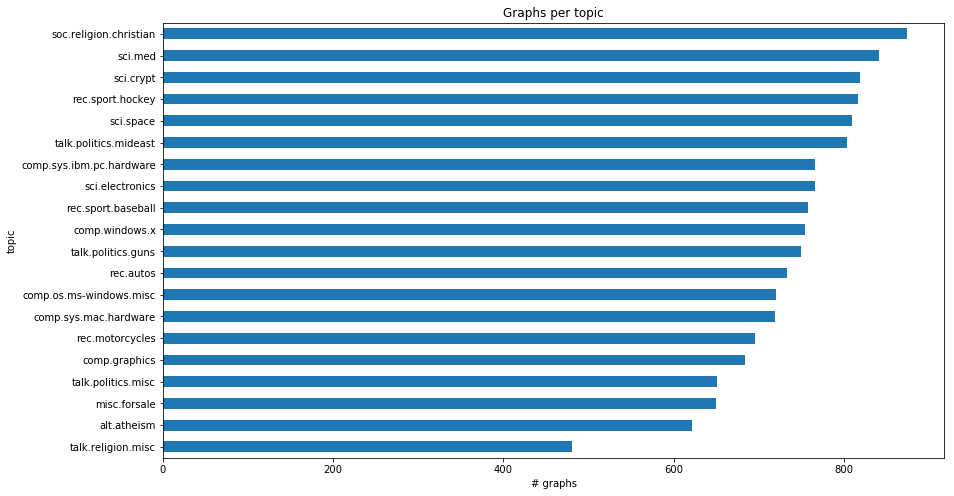

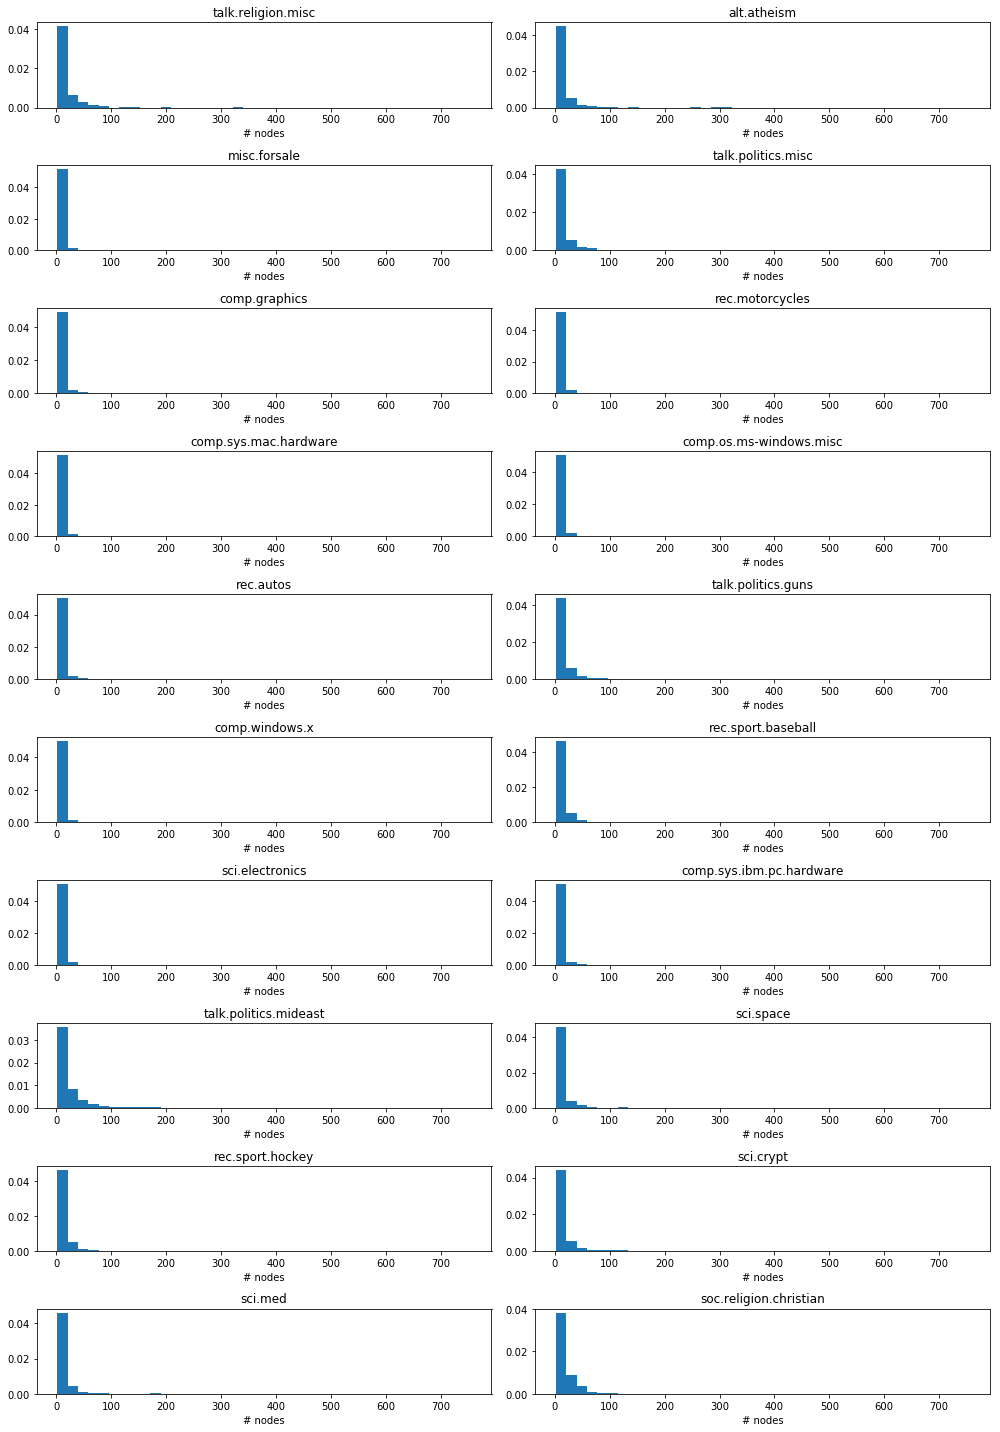

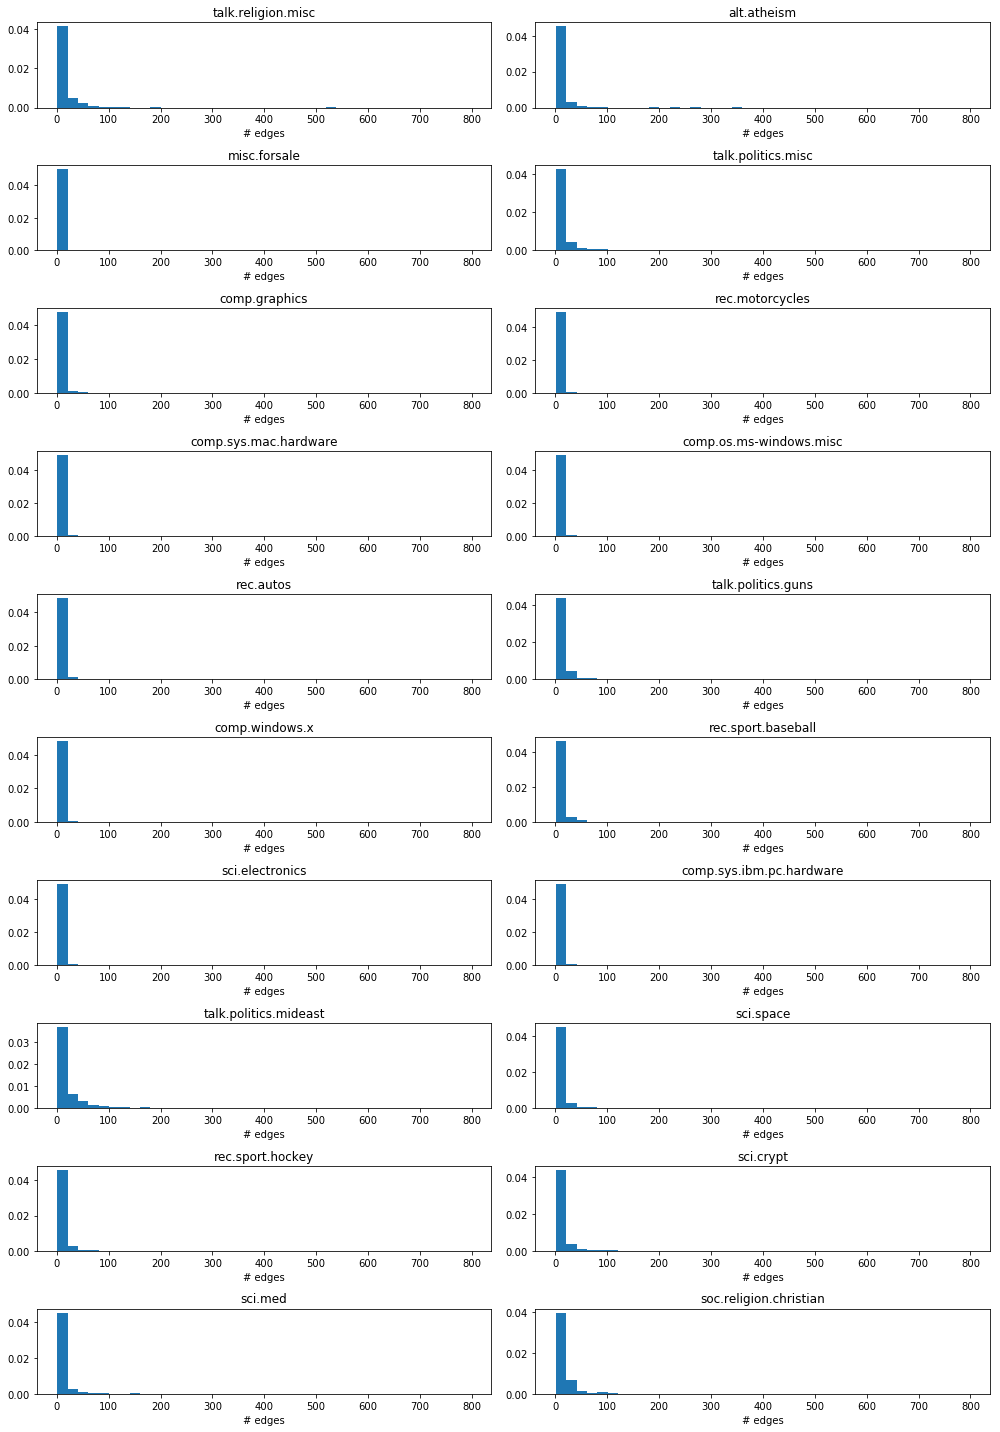

In [319]:
df_graphs_per_topic = pd.DataFrame([(topic, len(graphs), [len(x.nodes()) for x in graphs], [len(x.edges()) for x in graphs]) for topic, graphs in graphs_per_topic.items()], columns = ['topic', 'num_graphs', 'num_nodes', 'num_edges']).set_index(['topic']).sort_values(by = 'num_graphs')
ax = df_graphs_per_topic.plot.barh(title = 'Graphs per topic', legend = False, figsize = (14, 8))
ax.set_xlabel('# graphs')

def get_range_of(df, column):
    return df[column].apply(lambda x: min(x)).min(), df[column].apply(lambda x: max(x)).max()

nodes_range = get_range_of(df_graphs_per_topic, 'num_nodes')
edges_range = get_range_of(df_graphs_per_topic, 'num_edges')
plt.show()
ncols, nrows = (2, 10)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize = (14, 20))
fig_, axes_ = plt.subplots(ncols=ncols, nrows=nrows, figsize = (14, 20))
for idx, (topic, (num_graphs, num_nodes, num_edges)) in enumerate(df_graphs_per_topic.iterrows()):
    row = int(idx / ncols)
    col = idx % ncols
    ax = axes[row][col]
    ax_ = axes_[row][col]
    
    # 
    ax.set_title("{}".format(topic))
    ax.set_xlabel('# nodes')
    ax.hist(num_nodes, bins=40, normed = True, range = nodes_range)
    
    #
    ax_.set_title("{}".format(topic))
    ax_.set_xlabel('# edges')
    ax_.hist(num_edges, bins=40, normed = True, range = edges_range)
fig.tight_layout()
fig_.tight_layout()
plt.show()

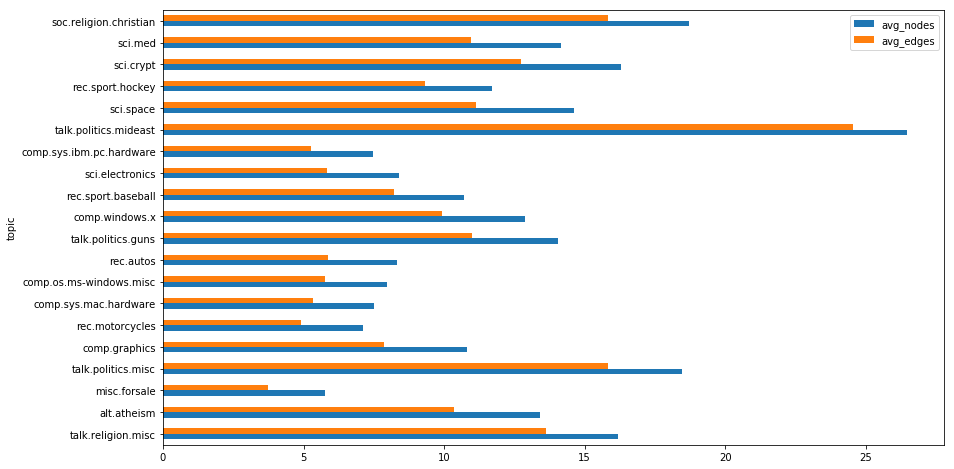

In [366]:
df_graphs_per_topic['avg_nodes'] = df_graphs_per_topic.num_nodes.apply(lambda x: np.mean(x))
df_graphs_per_topic['avg_edges'] = df_graphs_per_topic.num_edges.apply(lambda x: np.mean(x))
df_graphs_per_topic.plot(kind = 'barh', y = ['avg_nodes', 'avg_edges'], figsize = (14, 8))
plt.show()

## Filter categories

In [367]:
REMOVE_CATEGORIES = ['misc.forsale', 'comp.graphics']
REMOVE_CATEGORIES = []
graphs = graphs_per_topic.copy()
docs = docs_per_topic.copy()
if len(REMOVE_CATEGORIES):
    for cat in REMOVE_CATEGORIES:
        del graphs[cat]
        del docs[cat]

In [368]:
all_graphs = flatten(graphs.values())
all_docs = flatten(docs.values())

In [370]:
all_nodes = set()
for g in all_graphs:
    all_nodes |= set(g.nodes())

In [ ]:
print('#docs:\t\t{}\n#graphs:\t{}'.format(len(all_docs), len(all_graphs)))
print('Unique tokens found: {}'.format(len(all_nodes)))
assert len(all_docs) == len(all_graphs)

## Create train/test split

In [384]:
def get_train_test_split(topic_graphs, train_split_ratio = 0.8):
    train = []
    test = []
    num_elements = {}
    for topic, graphs in topic_graphs.items():
        num_elements_train = int(len(graphs) * train_split_ratio)
        train += [(topic, x) for x in graphs[:num_elements_train]]
        test += [(topic, x) for x in graphs[num_elements_train:]]
    return train, test

train, test = get_train_test_split(graphs)

In [385]:
print('#graphs\n\ttrain:\t{}\n\ttest:\t{}'.format(len(train), len(test)))

#graphs
	train:	11760
	test:	2950


In [375]:
H = 2

## Calculate phi and gram-matrix of WL kernel for training instances

In [386]:
adjs = []
nodes = []
for topic, graph in train:
    sorted_nodes = sorted(graph.nodes())
    adjs.append(nx.adjacency_matrix(graph, nodelist = sorted_nodes))
    nodes.append(sorted_nodes)
    
print('Calculating WL_train: start', psutil.virtual_memory())
K_train, phi_list_train, label_lookup_train, label_counters_train = WL_compute(adjs, nodes, H, all_nodes = all_nodes, DEBUG = True, compute_k = False)
print('Calculating WL_train: end', psutil.virtual_memory())

Calculating WL_train: start svmem(total=8589934592, available=3427201024, percent=60.1, used=7984754688, free=527044608, active=3581186048, inactive=2900156416, wired=1503412224)
Number of original labels 125441
K original is computed
Iteration 0: phi is computed
	Graph          0/11760
	Graph       1000/11760
	Graph       2000/11760
	Graph       3000/11760
	Graph       4000/11760
	Graph       5000/11760
	Graph       6000/11760
	Graph       7000/11760
	Graph       8000/11760
	Graph       9000/11760
	Graph      10000/11760
	Graph      11000/11760
Number of compressed labels 127200
Itaration 0: phi computed
Iteration 1: phi is computed
	Graph          0/11760
	Graph       1000/11760
	Graph       2000/11760
	Graph       3000/11760
	Graph       4000/11760
	Graph       5000/11760
	Graph       6000/11760
	Graph       7000/11760
	Graph       8000/11760
	Graph       9000/11760
	Graph      10000/11760
	Graph      11000/11760
Number of compressed labels 127499
Itaration 1: phi computed
Calculati

## Train classifier with the phi s of the training instances

In [416]:
clf = sklearn.linear_model.Perceptron(n_iter = 500, verbose = False, n_jobs = -1)
X = phi_list_train[-1].T
Y = [topic for topic, graphs in train]
clf.fit(X, Y)

Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=500, n_jobs=-1, penalty=None, random_state=0, shuffle=True,
      verbose=False, warm_start=False)

## Get predictions for test instances

### Calculate test phi s

In [417]:
def get_prediction(topic, graph):
    return compute_phi(graph, phi_list_train[0].shape, label_lookup_train, label_counters_train, h = H)[-1]

USED_SET = test
PARALLEL_PREDICTION_JOBS = 0
t = time()

if PARALLEL_PREDICTION_JOBS > 1:
    phi_test = Parallel(n_jobs=PARALLEL_PREDICTION_JOBS)(delayed(get_prediction)(*d) for d in list(USED_SET))
else:
    phi_test = [get_prediction(*d) for d in USED_SET]
print('Time: {:.2f}s'.format(time() - t, PARALLEL_PREDICTION_JOBS))

Time: 38.40s


### Predict test instances

In [418]:
%%time
def calculate_batches(l, fn, num_batches = 100):
    elements = []
    num_elements_per_batch = math.ceil(len(l) / num_batches)
    print('Starting: #elements: {}, #batches: {}, #elements per Batch: {}'.format(len(l), num_batches, num_elements_per_batch))
    for idx in range(num_batches):
        start = idx * num_elements_per_batch
        end = min(len(l), start + num_elements_per_batch)
        if idx % 10 == 0: print('\tIteration: {:>4}/{}'.format(idx, num_batches))
        if end - start <= 0:
            break
        elements += fn(l[start:end]).tolist()
    return elements
predicted = calculate_batches(phi_test, clf.predict)

Starting: #elements: 2950, #batches: 100, #elements per Batch: 30
	Iteration:    0/100
	Iteration:   10/100
	Iteration:   20/100
	Iteration:   30/100
	Iteration:   40/100
	Iteration:   50/100
	Iteration:   60/100
	Iteration:   70/100
	Iteration:   80/100
	Iteration:   90/100
CPU times: user 6.17 s, sys: 3.56 s, total: 9.73 s
Wall time: 10 s


### Metrics

In [458]:
Y_real = [topic for topic,graph in USED_SET]
Y_pred = predicted

#### About sparsity of test phi

In [459]:
df_phi_test_non_zero_elements = pd.DataFrame(list(zip(Y_real, Y_pred, [np.count_nonzero(x) for x in phi_test])), columns = ['real_topic', 'pred_topic', 'num_phi_non_zero'])

In [464]:
display(df_phi_test_non_zero_elements.groupby(by = 'real_topic').describe())
display(df_phi_test_non_zero_elements.groupby(by = 'pred_topic').describe())

num_phi_non_zero                                  \
                                    count       mean        std  min  25%   
real_topic                                                                  
alt.atheism                         125.0   9.432000  20.178772  1.0  2.0   
comp.graphics                       137.0   6.700730  26.738484  1.0  2.0   
comp.os.ms-windows.misc             144.0   4.430556   3.781909  1.0  2.0   
comp.sys.ibm.pc.hardware            154.0   4.811688   5.752828  1.0  2.0   
comp.sys.mac.hardware               144.0   4.375000   3.627546  1.0  2.0   
comp.windows.x                      151.0   9.278146  37.878606  1.0  2.0   
misc.forsale                        130.0   4.430769   4.466826  1.0  2.0   
rec.autos                           147.0   6.081633   7.441562  1.0  2.0   
rec.motorcycles                     139.0   6.079137  14.594552  1.0  2.0   
rec.sport.baseball                  152.0   6.177632   5.633511  1.0  3.0   
rec.sport.hockey                    164.0   7.231707   7.010595  1.0  3.0   
sci.crypt                           164.0  12.304878  30.562292  1.0  3.0   
sci.electronics                     154.0   7.564935  31.174802  1.0  2.0   
sci.med                             169.0   9.396450  22.686061  1.0  3.0   
sci.space                           162.0   8.000000  10.467341  1.0  2.0   
soc.religion.christian              175.0  12.017143  16.729929  1.0  4.0   
talk.politics.guns                  150.0  10.286667  14.882239  1.0  3.0   
talk.politics.mideast               161.0  15.937888  28.685730  1.0  3.0   
talk.politics.misc                  131.0  11.625954  25.612297  1.0  3.0   
talk.religion.misc                   97.0   8.443299  10.186765  1.0  3.0   

                                             
                          50%    75%    max  
real_topic                                   
alt.atheism               4.0   9.00  184.0  
comp.graphics             3.0   6.00  314.0  
comp.os.ms-windows.misc   3.0   5.00   23.0  
comp.sys.ibm.pc.hardware  4.0   5.75   59.0  
comp.sys.mac.hardware     3.0   6.00   26.0  
comp.windows.x            4.0   6.00  393.0  
misc.forsale              3.0   6.00   24.0  
rec.autos                 4.0   7.00   69.0  
rec.motorcycles           3.0   6.00  169.0  
rec.sport.baseball        4.0   8.00   39.0  
rec.sport.hockey          5.0  10.00   60.0  
sci.crypt                 6.0  10.00  332.0  
sci.electronics           4.0   6.00  388.0  
sci.med                   4.0   8.00  206.0  
sci.space                 4.0   9.00   62.0  
soc.religion.christian    7.0  12.00  114.0  
talk.politics.guns        5.0  11.00  132.0  
talk.politics.mideast     7.0  14.00  243.0  
talk.politics.misc        5.0  10.00  208.0  
talk.religion.misc        4.0   9.00   52.0

num_phi_non_zero                                   \
                                    count       mean        std  min   25%   
pred_topic                                                                   
alt.atheism                          60.0  11.266667  15.536580  2.0  4.00   
comp.graphics                        45.0  15.200000  46.241756  2.0  4.00   
comp.os.ms-windows.misc              65.0   7.876923   9.233952  2.0  3.00   
comp.sys.ibm.pc.hardware             50.0   6.500000   4.258245  2.0  4.00   
comp.sys.mac.hardware               111.0   6.333333   4.300810  2.0  3.00   
comp.windows.x                       97.0  16.948454  47.860990  2.0  4.00   
misc.forsale                       1370.0   3.805839  11.028960  1.0  2.00   
rec.autos                            36.0   8.638889   6.206691  2.0  3.75   
rec.motorcycles                     159.0   6.584906   4.523220  2.0  3.00   
rec.sport.baseball                  108.0  10.018519   9.285685  2.0  4.75   
rec.sport.hockey                    101.0   9.732673   9.500412  2.0  4.00   
sci.crypt                            88.0  21.920455  43.615409  2.0  4.00   
sci.electronics                      65.0  10.876923  14.071811  2.0  4.00   
sci.med                              88.0  14.295455  29.879128  2.0  4.00   
sci.space                            66.0   9.818182  10.250567  2.0  4.00   
soc.religion.christian              131.0  13.526718  21.369039  2.0  3.50   
talk.politics.guns                   61.0  11.131148  13.428174  2.0  4.00   
talk.politics.mideast               128.0  21.101562  31.048562  2.0  6.00   
talk.politics.misc                   85.0  14.905882  32.456793  2.0  3.00   
talk.religion.misc                   36.0  11.833333  15.251229  2.0  4.00   

                                              
                           50%    75%    max  
pred_topic                                    
alt.atheism                6.0  13.00  109.0  
comp.graphics              7.0   9.00  314.0  
comp.os.ms-windows.misc    5.0   7.00   59.0  
comp.sys.ibm.pc.hardware   5.0   8.00   24.0  
comp.sys.mac.hardware      5.0   7.50   29.0  
comp.windows.x             6.0  12.00  393.0  
misc.forsale               3.0   4.00  388.0  
rec.autos                  7.5  10.50   30.0  
rec.motorcycles            5.0   8.00   29.0  
rec.sport.baseball         8.0  12.00   53.0  
rec.sport.hockey           7.0  13.00   61.0  
sci.crypt                 10.0  18.00  332.0  
sci.electronics            7.0  11.00   86.0  
sci.med                    6.0  12.00  206.0  
sci.space                  7.0   9.00   62.0  
soc.religion.christian     7.0  15.00  184.0  
talk.politics.guns         5.0  12.00   72.0  
talk.politics.mideast     12.0  23.25  243.0  
talk.politics.misc         6.0  12.00  208.0  
talk.religion.misc         6.0  10.50   65.0

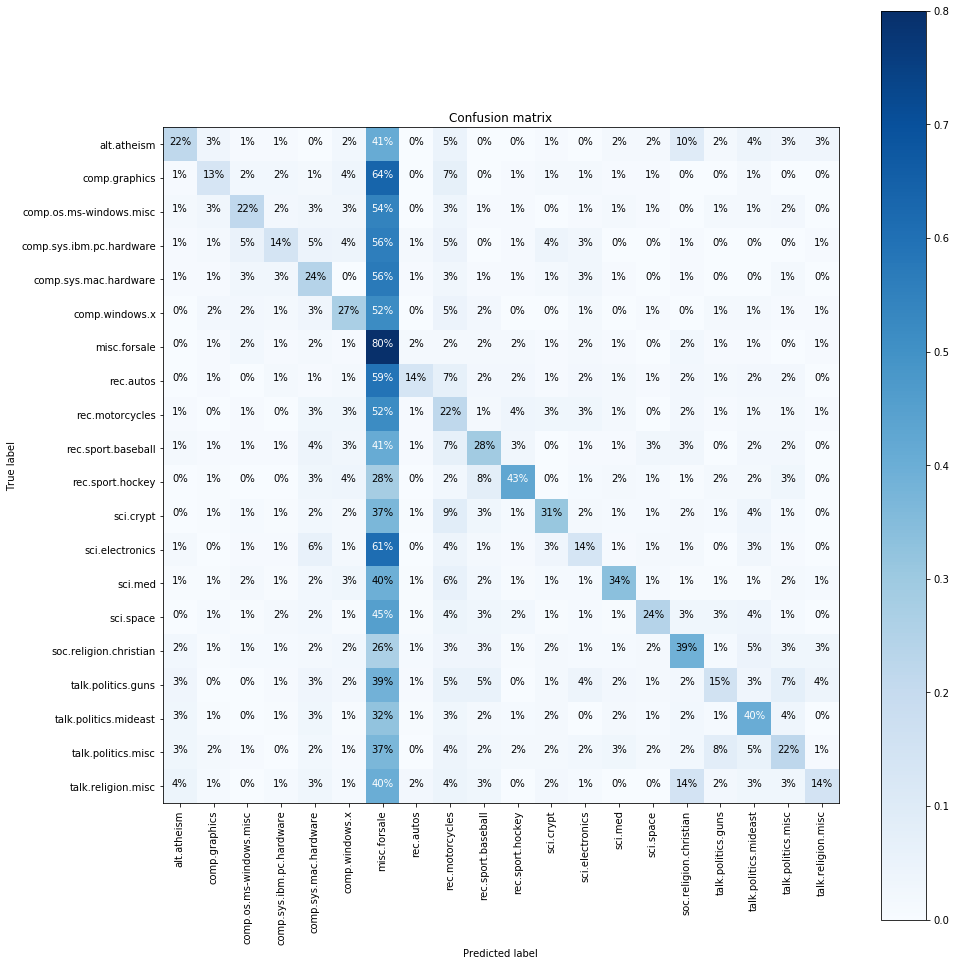

In [420]:
cf_mat = sklearn.metrics.confusion_matrix(Y_real, Y_pred)
fig = plt.figure(figsize=(14, 14))
helper.plot_confusion_matrix(cf_mat, clf.classes_, normalize = True)
plt.show()

In [421]:
with open('data/graphs.npy', 'wb') as f:
    pickle.dump({
            'train': train,
            'test': test,
            'K_train': K_train,
            'phi_list_train': phi_list_train,
            'label_lookup_train': label_lookup_train,
            'label_counters_train': label_counters_train
    }, f)